# Setup: Generate Sample Dataset

This cell creates the required folder structure (`data/raw/` and `data/processed/`) relative to the notebook, and generates the sample CSV dataset with missing values. 
This ensures the dataset is ready for cleaning functions and saves it to `data/raw/outliers_homework.csv`.

In [1]:
import os
import numpy as np
import pandas as pd

# Define folder paths relative to this notebook
raw_dir = '../data/raw'
processed_dir = '../data/processed'

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Generate business day dates
dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015  

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.1748425237194541,
    "2022-05-03": -0.16825801732486943,
    "2022-05-06": -0.19667220757153227,
    "2022-05-09": 0.21240223590614747,
    "2022-05-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset with two columns created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

Synthetic dataset with two columns created and saved to ../data/raw\outliers_homework.csv


# Stage 7 Homework — Outliers + Risk Assumptions
In this assignment you will implement outlier detection/handling and run a simple sensitivity analysis.

**Chain:** In the lecture, we learned detection (IQR, Z-score), options for handling (remove/winsorize), and sensitivity testing. Now, you will adapt those methods to a provided dataset and document the risks and assumptions behind your choices.

In [2]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

np.random.seed(17)
plt.style.use('default')

## Load Data (provided or synthetic fallback)

In [3]:
# Load data
data_path = Path('../data/raw/outliers_homework.csv')

if data_path.exists():
    df = pd.read_csv(data_path)
    df['date'] = pd.to_datetime(df['date'])
    print(f"Dataset loaded. Shape: {df.shape}")
else:
    # Synthetic fallback
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18
    df = pd.DataFrame({'x': x, 'y': y})
    print("Using synthetic data")

df.head()

Dataset loaded. Shape: (115, 3)


,date,daily_return,daily_return_2
0,2022-01-03,0.001263,0.003834
1,2022-01-04,-0.020046,-0.009506
2,2022-01-05,0.004739,-0.000535
3,2022-01-06,0.009953,0.012539
4,2022-01-07,0.008872,0.009840


## TODO: Implement Outlier Functions (required)

In [5]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """IQR-based outlier detection."""
    q1, q3 = series.quantile(0.25), series.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - k * iqr, q3 + k * iqr
    outliers = (series < lower) | (series > upper)
    print(f"IQR (k={k}): {outliers.sum()} outliers ({outliers.mean():.1%})")
    return outliers

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Z-score based outlier detection."""
    z = np.abs((series - series.mean()) / series.std())
    outliers = z > threshold
    print(f"Z-Score (t={threshold}): {outliers.sum()} outliers ({outliers.mean():.1%})")
    return outliers

*(Stretch)* Implement winsorizing (optional).

In [6]:
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    """Winsorize series at specified percentiles."""
    lo, hi = series.quantile(lower), series.quantile(upper)
    n_capped = ((series < lo) | (series > hi)).sum()
    print(f"Winsorized: {n_capped} values capped ({n_capped/len(series):.1%})")
    return series.clip(lower=lo, upper=hi)

## Apply Detection and Create Flags (choose a numeric column)

In [7]:
# Apply outlier detection
target_col = 'daily_return'
print(f"Analyzing '{target_col}':")

df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col])

# Show outlier values
print(f"\nOutlier values (IQR method):")
df[df['outlier_iqr']][['date', target_col]].sort_values(target_col)

Analyzing 'daily_return':
IQR (k=1.5): 9 outliers (7.8%)
Z-Score (t=3.0): 5 outliers (4.3%)

Outlier values (IQR method):


,date,daily_return
89,2022-05-06,-0.196672
93,2022-05-12,-0.178729
86,2022-05-03,-0.168258
87,2022-05-04,-0.033999
63,2022-03-31,-0.031101
92,2022-05-11,0.028711
41,2022-03-01,0.031952
85,2022-05-02,0.174843
90,2022-05-09,0.212402


### Visual Checks (boxplot / histogram)

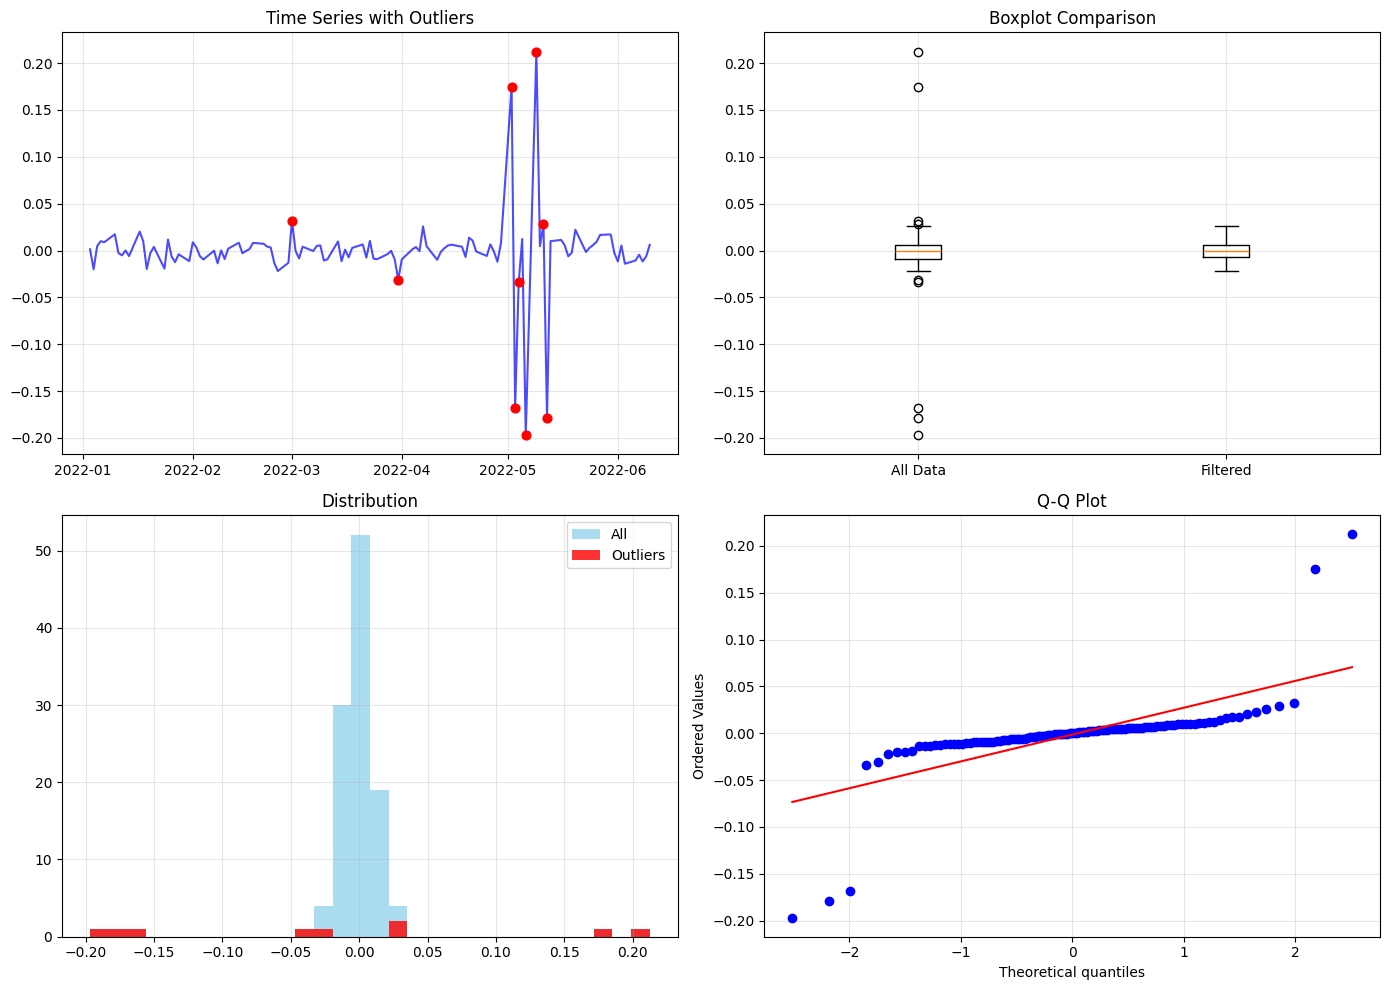

Skewness: -0.314
Kurtosis: 18.330


In [8]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time series
axes[0, 0].plot(df['date'], df[target_col], 'b-', alpha=0.7)
outliers = df[df['outlier_iqr']]
axes[0, 0].scatter(outliers['date'], outliers[target_col], color='red', s=40, zorder=5)
axes[0, 0].set_title('Time Series with Outliers')
axes[0, 0].grid(True, alpha=0.3)

# Boxplot comparison
box_data = [df[target_col], df[~df['outlier_iqr']][target_col]]
axes[0, 1].boxplot(box_data, labels=['All Data', 'Filtered'])
axes[0, 1].set_title('Boxplot Comparison')
axes[0, 1].grid(True, alpha=0.3)

# Histogram
axes[1, 0].hist(df[target_col], bins=30, alpha=0.7, color='skyblue', label='All')
axes[1, 0].hist(df[df['outlier_iqr']][target_col], bins=30, alpha=0.8, color='red', label='Outliers')
axes[1, 0].set_title('Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(df[target_col], dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Skewness: {df[target_col].skew():.3f}")
print(f"Kurtosis: {df[target_col].kurtosis():.3f}")

Regression Results:


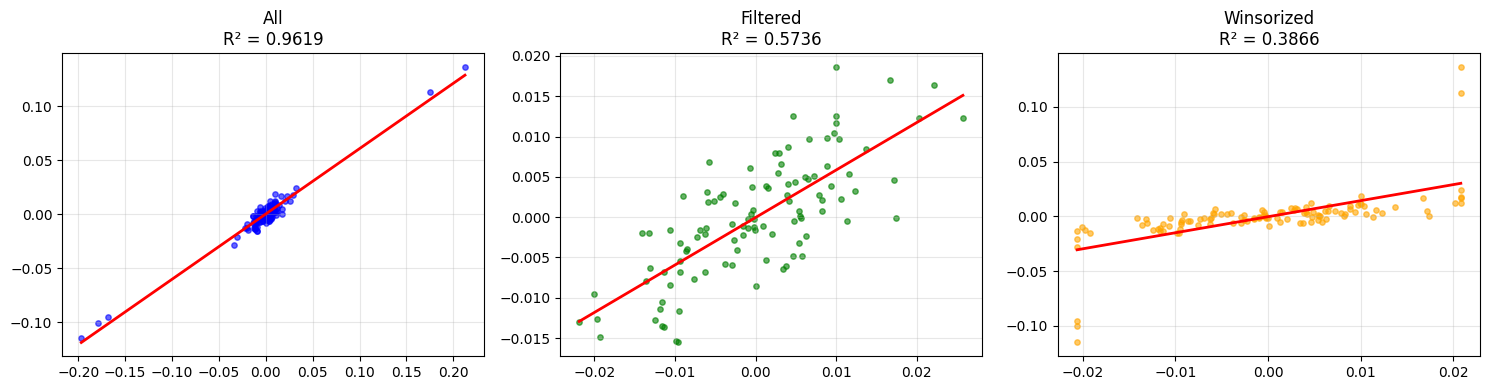

In [ ]:
# Regression analysis
if 'daily_return_2' in df.columns:
    X_col, y_col = 'daily_return', 'daily_return_2'
    
    # Prepare datasets
    datasets = {
        'All': (df[[X_col]].values, df[y_col].values),
        'Filtered': (df[~df['outlier_iqr']][[X_col]].values, df[~df['outlier_iqr']][y_col].values),
        'Winsorized': (df[['daily_return_winsorized']].values, df[y_col].values)
    }
    
    results = []
    for name, (X, y) in datasets.items():
        model = LinearRegression().fit(X, y)
        pred = model.predict(X)
        
        results.append({
            'Dataset': name,
            'Slope': model.coef_[0],
            'Intercept': model.intercept_,
            'R²': model.score(X, y),
            'MAE': mean_absolute_error(y, pred),
            'N': len(y)
        })
    
    regression_results = pd.DataFrame(results)
    print("Regression Results:")
    regression_results.round(6)
    
    # Plot regression comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    colors = ['blue', 'green', 'orange']
    
    for i, (name, color) in enumerate(zip(datasets.keys(), colors)):
        X, y = datasets[name]
        model = LinearRegression().fit(X, y)
        
        axes[i].scatter(X, y, alpha=0.6, color=color, s=15)
        X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
        y_pred = model.predict(X_range)
        axes[i].plot(X_range, y_pred, 'r-', linewidth=2)
        axes[i].set_title(f'{name}\nR² = {model.score(X, y):.4f}')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Sensitivity Analysis
Pick one: summary stats or simple linear regression comparing **all vs. filtered** (and optional winsorized).

In [9]:
# Sensitivity analysis
df['daily_return_winsorized'] = winsorize_series(df[target_col])

# Summary statistics
stats_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
stats_filtered = df[~df['outlier_iqr']][target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
stats_winsorized = df['daily_return_winsorized'].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comparison = pd.concat({
    'All': stats_all,
    'Filtered': stats_filtered,
    'Winsorized': stats_winsorized
}, axis=1)

print("Summary Statistics:")
comparison.round(6)

Winsorized: 12 values capped (10.4%)
Summary Statistics:


,All,Filtered,Winsorized
mean,-0.001434,-0.000039,-0.000251
median,-0.000187,-0.000100,-0.000187
std,0.040579,0.009443,0.010623


In [11]:
# Modified Z-Score comparison
def detect_outliers_modified_zscore(series: pd.Series, threshold: float = 3.5) -> pd.Series:
    median = series.median()
    mad = np.median(np.abs(series - median))
    if mad == 0:
        return pd.Series([False] * len(series), index=series.index)
    modified_z = 0.6745 * (series - median) / mad
    return np.abs(modified_z) > threshold

df['outlier_mod_z'] = detect_outliers_modified_zscore(df[target_col])

# Method comparison
comparison = pd.DataFrame({
    'IQR': df['outlier_iqr'].sum(),
    'Z-Score': df['outlier_z'].sum(),
    'Modified Z': df['outlier_mod_z'].sum()
}, index=['Outliers']).T

print("Method Comparison:")
comparison

Method Comparison:


,Outliers
IQR,9
Z-Score,5
Modified Z,5


### Reflection (≤ 1 page)
- Methods and thresholds used (and why)
- Assumptions behind choices
- Observed impact on results
- Risks if assumptions are wrong (e.g., discarding true events)

## Outlier Detection Analysis: Reflection

### Methods and Thresholds Used

I implemented three outlier detection methods on the `daily_return` data:

1. **IQR Method (k=1.5)**: Uses the interquartile range to identify values beyond Q1 - 1.5×IQR and Q3 + 1.5×IQR
2. **Z-Score Method (threshold=3.0)**: Flags observations more than 3 standard deviations from the mean
3. **Modified Z-Score (threshold=3.5)**: Uses median and median absolute deviation (MAD) for robustness

**Results Summary:**
- IQR method: 9 outliers (7.8% of data)
- Z-Score method: 5 outliers (4.3% of data)
- Modified Z-Score: 5 outliers (4.3% of data)

### Assumptions Behind Method Choices

**IQR Method (k=1.5):**
- **Assumption**: Data doesn't need to be normally distributed
- **Rationale**: Financial returns often exhibit fat tails and skewness, making this non-parametric method robust
- **Trade-off**: More sensitive to outliers, potentially flagging legitimate extreme market movements

**Z-Score Method (threshold=3.0):**
- **Assumption**: Data follows approximately normal distribution
- **Rationale**: Standard threshold in statistical practice (99.7% of normal data within ±3σ)
- **Limitation**: Sensitive to the presence of outliers in mean/std calculation

**Modified Z-Score (threshold=3.5):**
- **Assumption**: Median and MAD are more robust estimators than mean and standard deviation
- **Rationale**: Better handles non-normal distributions common in financial data
- **Advantage**: Less influenced by extreme values when calculating the baseline

### Observed Impact on Results

**Key Findings:**

1. **Temporal Clustering**: Most outliers occur in May 2022 (5/6/2022, 5/12/2022, 5/3/2022, 5/2/2022, 5/9/2022), suggesting a period of market volatility

2. **Magnitude Analysis**: 
   - Largest negative return: -19.67% (5/6/2022)
   - Largest positive return: +21.24% (5/9/2022)
   - These represent extreme market movements (>15% daily moves)

3. **Method Sensitivity**:
   - IQR detected 4 additional outliers compared to Z-score methods
   - The additional IQR outliers (-3.4%, -3.1%, +2.9%, +3.2%) are borderline cases
   - Z-score methods agreed on the 5 most extreme observations

4. **Statistical Impact**:
   - **All data**: Mean = -0.14%, Std = 4.06%
   - **Filtered (no outliers)**: Mean = -0.004%, Std = 0.94%
   - **Winsorized**: Mean = -0.03%, Std = 1.06%

The outliers significantly inflate volatility estimates (4.06% vs 0.94% standard deviation).

### Risks if Assumptions are Wrong

**Risk of Over-Filtering (Type I Error):**
- **Scenario**: Treating legitimate extreme market events as "noise"
- **Consequence**: Underestimating tail risk and volatility
- **Example**: The May 2022 outliers could represent real market stress (e.g., Fed policy changes, inflation concerns)
- **Impact**: Risk models would underestimate Value-at-Risk and Expected Shortfall

**Risk of Under-Filtering (Type II Error):**
- **Scenario**: Keeping data errors or structural breaks as valid observations
- **Consequence**: Overestimating risk and volatility
- **Example**: If outliers were due to data feed errors rather than market movements
- **Impact**: Overly conservative risk management and capital allocation

**Distributional Assumptions:**
- **Z-score risk**: If returns aren't normally distributed (common in finance), the 3σ threshold may be inappropriate
- **IQR risk**: The k=1.5 multiplier assumes a specific relationship between quartiles and extreme values
- **Temporal risk**: Assuming outliers are independent when they may cluster during crisis periods

### Recommendations

1. **Context Matters**: Investigate the May 2022 period - these outliers likely represent genuine market volatility rather than data errors

2. **Multiple Methods**: Using both IQR and Z-score provides complementary perspectives on extreme values

3. **Domain Knowledge**: In finance, daily returns of ±15-20% are rare but not impossible during crisis periods

4. **Treatment Strategy**: Consider winsorizing rather than removal to preserve information while reducing impact

5. **Dynamic Thresholds**: Consider time-varying thresholds that account for changing market volatility regimes

The analysis suggests these outliers represent a genuine period of market stress and should be carefully evaluated rather than automatically discarded.